In [1]:
import pygmo as pg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly
from plotly import graph_objs as go
from plotly import tools
import plotly.express as px
from ipywidgets import interact

In [69]:
# --- Problem

udp = pg.zdt(prob_id=4, param=12)
pro = pg.problem(udp)

In [94]:
from random import randrange, choice
from collections import namedtuple

def samples(problem, n=10, random=True):
    lin = []
    for b in zip(*problem.get_bounds()):
        lin.append(np.linspace(b[0], b[1], 20+randrange(30), endpoint=True))

    Point = namedtuple('Point', ['x{}'.format(i+1) for i in range(len(lin))])
    table = pd.DataFrame([Point(*[choice(d) for d in lin]) for _ in range(n)])       
    table[['f1', 'f2']] = table.apply(lambda row: pd.Series(problem.fitness(row)), axis=1) 
    
    if random is True:
        table['rand1'] = np.random.randint(1, 50, table.shape[0])
        table['rand2'] = np.random.randint(1, 100, table.shape[0])
        table['rand3'] = np.random.randint(1, 250, table.shape[0])
        table['rand4'] = np.random.randint(1, 1000, table.shape[0])

    return table

In [95]:
samples = samples(pro, n=100)

In [174]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression

import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
# Kernel with parameters given in GPML book
k1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = 2.4**2 * RBF(length_scale=90.0) \
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.66**2 \
    * RationalQuadratic(length_scale=1.2, alpha=0.78)
k4 = 0.18**2 * RBF(length_scale=0.134) \
    + WhiteKernel(noise_level=0.19**2)  # noise terms
kernel_gpml = k1 + k3

np.random.seed(0)

preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', gp.GaussianProcessRegressor(kernel=kernel_gpml))
                     ])

X = samples.drop(['f1', 'f2'], axis=1)
y = samples['f1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("Pipeline model score: %.3f" % clf.score(X_test, y_test))


tree = gp.GaussianProcessRegressor(kernel=kernel_gpml)
tree.fit(X_train, y_train)
print("model score: %.3f" % tree.score(X_test, y_test))



# pd.DataFrame(preprocessor.transform(X_train))
# X_train.columns



Pipeline model score: 1.000
model score: -0.098


Feature ranking:


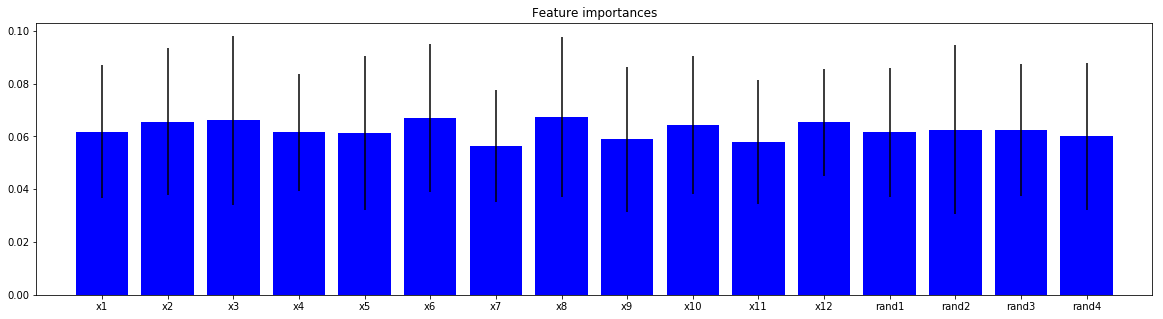

In [170]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# tree = DecisionTreeClassifier(max_depth = 3, random_state= 17)
# tree.fit(X_train, y_train)

forest = ExtraTreesClassifier(n_estimators=50)
forest.fit(X_train, (y_train*100).astype('int'))
# xlf.feature_importances_

# Print the feature ranking
print("Feature ranking:")
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

# Plot the feature importances of the forest
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances,
       color="b", yerr=std, align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [180]:
from sklearn.linear_model import LassoCV

# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LassoCV(cv=5)
# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=0.5)
sfm.fit(X_train, y_train)
n_features = sfm.transform(X_train).shape[1]

n_features

1